In [1]:
%matplotlib inline
from pylab import *
import cv2

In [2]:
rcParams['figure.figsize'] = 10, 10

In [3]:
from dataset import load_image

In [4]:
import torch

In [5]:
torch.cuda.empty_cache()

In [6]:
from utils import cuda

In [7]:
from generate_masks import get_model

In [8]:
from albumentations import Compose, Normalize

In [9]:
from albumentations.torch.functional import img_to_tensor

In [10]:
def img_transform(p=1):
    return Compose([
        Normalize(p=1)
    ], p=p)

In [11]:
def mask_overlay(image, mask, color=(0, 255, 0)):
    """
    Helper function to visualize mask on the top of the car
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]    
    return img

In [12]:
model_path = 'runs/debug/model.pt'
model = get_model(model_path, model_type='AlbuNet')

In [47]:
gt.max()

113

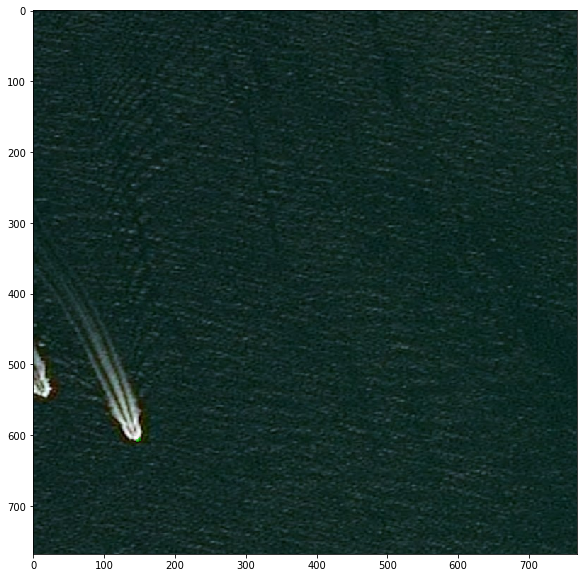

In [48]:
img = 'ca6dff65e'

img_file_name = '/home/raznem/proj_kaggle_airbus/data/test_v2/{}.jpg'.format(img)
gt_file_name = '1/{}.jpg'.format(img)

image = load_image(img_file_name)
gt = cv2.imread(gt_file_name, 0) > 100

imshow(mask_overlay(image, gt))

In [92]:
with torch.no_grad():
    input_image = torch.unsqueeze(img_to_tensor(img_transform(p=1)(image=image)['image']).cuda(), dim=0)

In [20]:
mask = model(input_image)

/home/agaidash/anastasiia/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [21]:
mask_array = mask.data[0].cpu().numpy()[0]

In [5]:
# imshow(mask_overlay(image, (mask_array > 0).astype(np.uint8)))

In [6]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [7]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [8]:
from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img)
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

In [9]:
import gc; gc.enable() # memory is tight

In [10]:
from os import listdir

In [11]:
from skimage.io import imread
from tqdm import tqdm
out_pred_rows = []
for c_img_name in tqdm(listdir('1')):
    cur_rles = multi_rle_encode(cv2.imread('1/' + c_img_name, 0) > 0)
    if len(cur_rles)>0:
        for c_rle in cur_rles:
            out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': c_rle}]
    else:
        out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': None}]
    gc.collect()

100%|██████████| 15606/15606 [10:28<00:00, 24.81it/s]


In [12]:
import pandas as pd

submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
submission_df.sample(3)

,ImageId,EncodedPixels
56705,ca647dd1d.jpg,7905 1 8667 9 9433 12 10198 15 10963 19 11729 ...
6305,3f5119889.jpg,49886 6 50654 6 51421 7 52188 9 52956 9 53724 ...
40750,5fd4439df.jpg,236297 5 237065 7 237833 8 238601 8 239370 7 2...
